In [2]:
import sys
import os

# Insert the parent directory of "app" into sys.path
# so that Python recognizes "app" as an importable package.
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)

In [3]:
from dotenv import load_dotenv
load_dotenv()  # This looks for .env in the current working directory

True

In [4]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

from ragas import evaluate
from ragas.llms import LlamaIndexLLMWrapper

from app.workflows.utils import llm, graph_store

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [5]:
"""
import time
start = time.time()
from app.workflows.naive_text2cypher import NaiveText2CypherFlow
end = time.time()
print(f"Import took {end - start:.2f} seconds")
flow = NaiveText2CypherFlow(verbose=True, timeout=30)
"""

'\nimport time\nstart = time.time()\nfrom app.workflows.naive_text2cypher import NaiveText2CypherFlow\nend = time.time()\nprint(f"Import took {end - start:.2f} seconds")\nflow = NaiveText2CypherFlow(verbose=True, timeout=30)\n'

In [6]:
import time
start = time.time()
from app.workflows.naive_text2cypher_retry import NaiveText2CypherRetryFlow
end = time.time()
print(f"Import took {end - start:.2f} seconds")
flow = NaiveText2CypherRetryFlow(verbose=False, timeout=30)

/Users/tomazbratanic/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Import took 0.92 seconds


In [7]:
import pandas as pd

test_df = pd.read_csv('test_data.csv', delimiter=";")
test_df.head()

,Question,Cypher
0,Who acted in Tom Hanks’s highest-rated movie?,MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_I...
1,Which movie starring Keanu Reeves has the most...,"MATCH (meg:Actor {name: ""Keanu Reeves""})-[:ACT..."
2,Who directed the most recent movie starring Ha...,"MATCH (p:Person {name: ""Halle Berry""})-[:ACTED..."
3,What is the highest-rated movie from the 1990s...,MATCH (m:Movie)-[:DIRECTED]-(d:Person) WHERE m...
4,"For all movies starring Keanu Reeves, find the...","MATCH (keanu:Person {name: ""Keanu Reeves""})-[:..."


In [ ]:
results = []
latencies = []
ground_truth = []
for i, row in test_df.iterrows():
    question = row['Question']
    print(question)
    start = time.time()
    try:
        data = await flow.run(input=question)
    except:
        data = "timeout"
    try:
        ground_truth.append(graph_store.structured_query(row['Cypher']))
    except Exception as e:
        ground_truth.append("missing")
    end = time.time()
    latencies.append(end - start)
    results.append(data)
    print(data)

<Axes: ylabel='Count'>

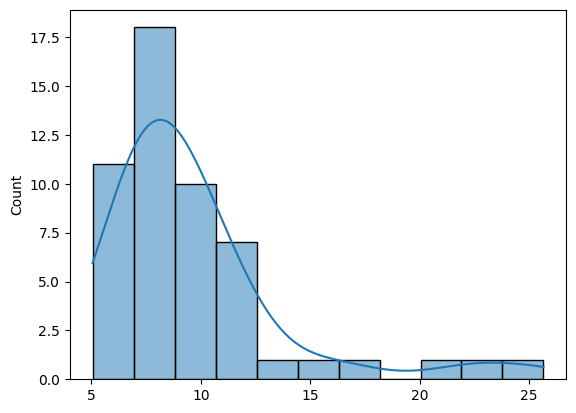

In [18]:
import seaborn as sns

sns.histplot(latencies, kde=True)

In [22]:
import pandas as pd
from ragas import evaluate
from datasets import Dataset



# Convert to DataFrame
df = pd.DataFrame(results) 
df['ground_truth'] = [str(el) for el in ground_truth] # Dates are causing troubles
df['latencies'] = latencies
# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(df)
df.head()

,cypher,question,answer,ground_truth,latencies
0,MATCH (p:Person {name: 'Tom Hanks'})-[:ACTED_I...,Who acted in Tom Hanks’s highest-rated movie?,"Based on the context provided, the actor who a...","[{'a.name': 'David Andrews', 'm.title': 'From ...",7.722855
1,MATCH (keanu:Person {name: 'Keanu Reeves'})-[:...,Which movie starring Keanu Reeves has the most...,"Based on the context provided, the movie starr...","[{'Movie': 'Lake House, The', 'CommonActors': 2}]",6.512080
2,MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title:...,Who directed the most recent movie starring Ha...,The context retrieved from the Neo4j database ...,"[{'director': 'Brad Anderson', 'mostRecentMovi...",8.774410
3,MATCH (m:Movie)-[:DIRECTED]-(d:Person) \nWHERE...,What is the highest-rated movie from the 1990s...,"The highest-rated movie from the 1990s is **""T...","[{'highestRatedMovie': 'Shawshank Redemption, ...",7.073416
4,"MATCH (keanu:Person {name: ""Keanu Reeves""})-[:...","For all movies starring Keanu Reeves, find the...",The provided context indicates that the Cypher...,"[{'director': 'Lana Wachowski', 'collaboration...",21.677038


In [14]:
result = evaluate(
    dataset,
    metrics=[
        answer_relevancy
    ],
    llm=LlamaIndexLLMWrapper(llm)
)

Evaluating:   0%|          | 0/52 [00:00<?, ?it/s]

In [15]:
result

{'answer_relevancy': 0.5429}

In [20]:
result_df = result.to_pandas()
result_df.to_csv('benchmark_output.csv', index=False)

<Axes: xlabel='answer_relevancy', ylabel='Count'>

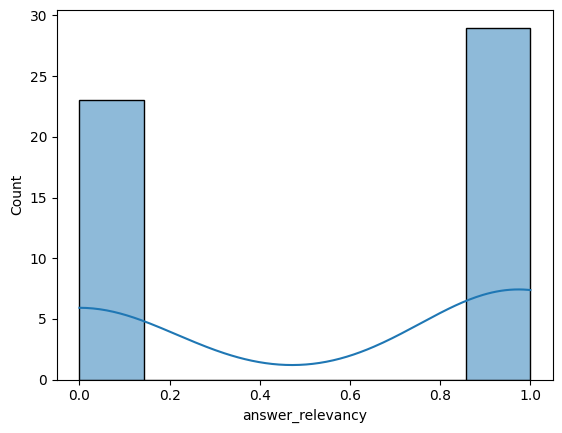

In [21]:
sns.histplot(result_df['answer_relevancy'], kde=True)